# Preprocessing data

In [1]:
%%capture
import nbimporter
import pandas as pd
from utils import TrainingSet, DataCleaner, CategoricalData
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
df = pd.read_csv('../data/housing/housing.csv')
dt = TrainingSet(df, test_size=0.25)
Ts, Xs = dt.stratified_test(column='median_house_value', strata=5)
X, L = TrainingSet.training_labels(Ts, ['median_house_value'])

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
tr_pipeline = Pipeline([
    ('cleaning', DataCleaner(text_attributes=['ocean_proximity'])),
    ('categorical', CategoricalData(text_attribute='ocean_proximity')),
    ('scaling', StandardScaler())
])

In [5]:
T = tr_pipeline.fit_transform(X)

# Fit model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from models import Predictor

Importing Jupyter notebook from models.ipynb


In [7]:
A = Predictor(LinearRegression(), T, L.values.ravel())
B = Predictor(DecisionTreeRegressor(), T, L.values.ravel())
C = Predictor(RandomForestRegressor(), T, L.values.ravel())

In [8]:
print (A.mse(), B.mse(), C.mse())

68969.20592623303 0.0 21730.66315828537


### Cross validation

In [9]:
scoreA, scoreB, scoreC = A.cross_validate(), B.cross_validate(), C.cross_validate()

In [10]:
print (scoreA.mean(), scoreA.std())
print (scoreB.mean(), scoreB.std())
print (scoreC.mean(), scoreC.std())

69149.83331109732 1738.002386829347
68519.75533503247 1880.4294019247288
51677.8601634419 1363.4000208573818


# Classification

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [12]:
methods = [
    ('Gaussian NB', GaussianNB()),
    ('Support Vector Machine', SVC()),
    ('KNN', KNeighborsClassifier(n_neighbors=20))
]
kr_pipeline = Pipeline([
    ('cleaning', DataCleaner(text_attributes=None)),
    ('scaling', StandardScaler())
])

In [13]:
Ks, O = TrainingSet.training_labels(Ts, ['ocean_proximity'])
K = kr_pipeline.fit_transform(Ks)

In [14]:
predictors = []
for m, model in methods:
    predictors.append(Predictor(model, K, O.values.ravel()))

In [19]:
cms = [p.confusion_matrix() for p in predictors]
labels = list(set(O.values.ravel()))

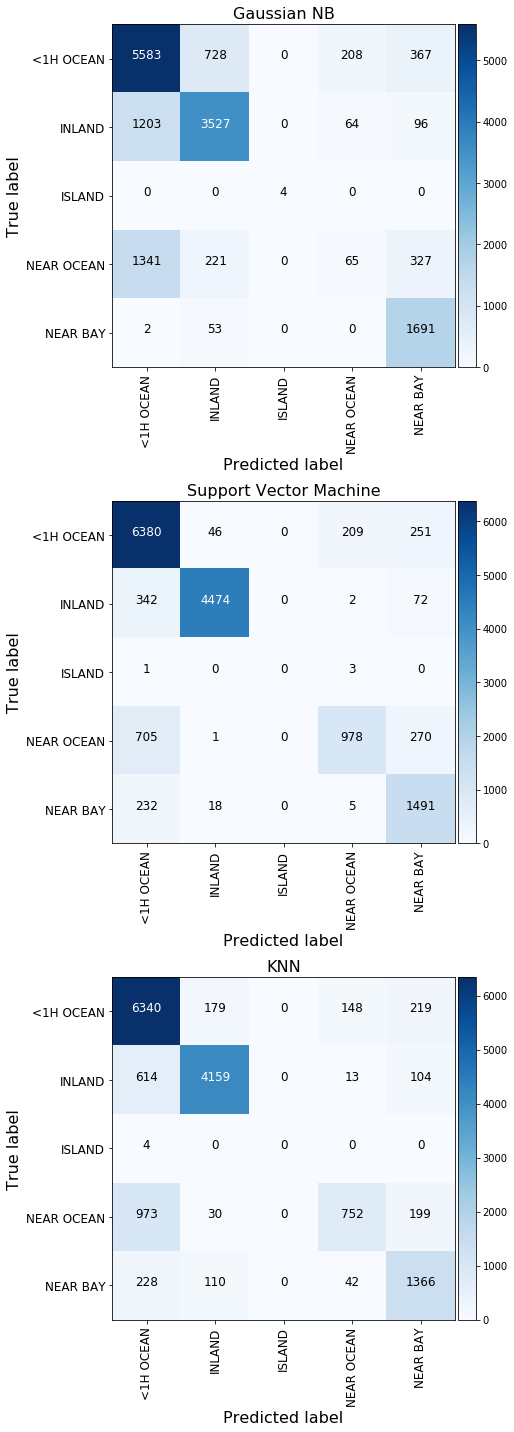

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 20))
Predictor.cm_plot(axes[0], labels, cms[0], 'Gaussian NB', fig)
Predictor.cm_plot(axes[1], labels, cms[1], 'Support Vector Machine', fig)
Predictor.cm_plot(axes[2], labels, cms[2], 'KNN', fig)
plt.tight_layout()
plt.show()